In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

import scipy.sparse 
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_squared_error
import gc


pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
# Check current versions

for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
scipy 1.2.1
lightgbm 2.3.0
seaborn 0.9.0


In [3]:
def downcast_dtypes(df):
    
    # Changes column types in the dataframe:
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
def rmse(*args):
    
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))

def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 20)

In [5]:
sales = pd.read_csv('data/sales_train.csv.gz')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv.gz')

### 1) EDA

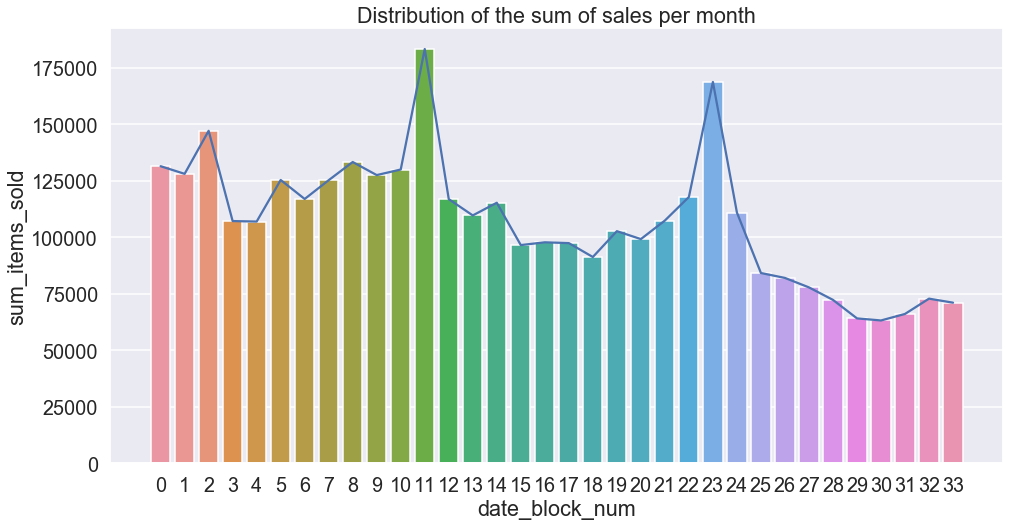

In [6]:
plt.figure(figsize=(16,8))
sns.set_context("talk", font_scale=1.2)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
del sales_month

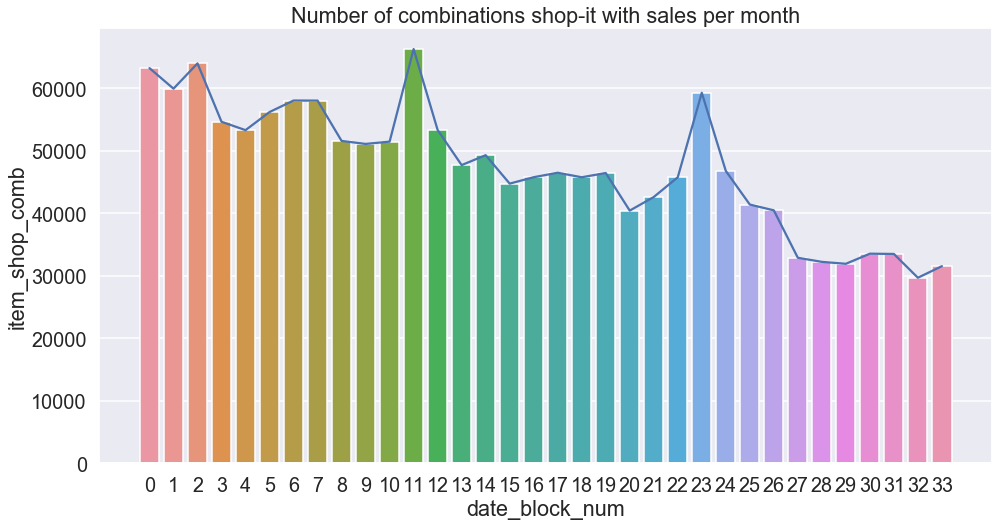

In [7]:
plt.figure(figsize=(16,8))
comb_shop_item = pd.DataFrame(sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item_shop_comb']
sns.barplot(x = 'date_block_num', y = 'item_shop_comb', data = comb_shop_item)
plt.plot(comb_shop_item['item_shop_comb'])
plt.title('Number of combinations shop-it with sales per month')
del comb_shop_item

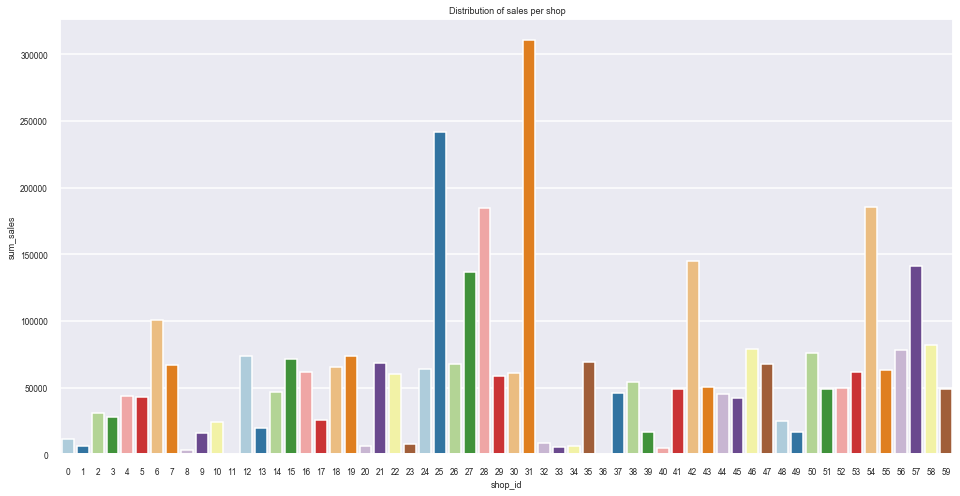

In [8]:
plt.figure(figsize=(16,8))
sns.set_context("talk", font_scale=0.5)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

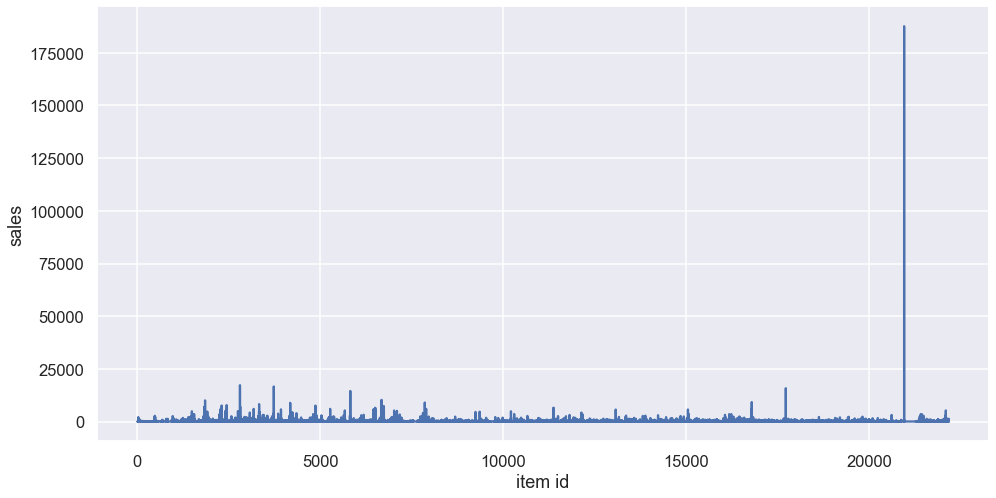

In [9]:
plt.figure(figsize=(16,8))
sns.set_context("talk", font_scale=1.0)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

In [10]:
#There is one item with an anomaly number of sales. The item id is:
anomaly_item = sales_item_id.item_cnt_day.argmax()
anomaly_item

20949

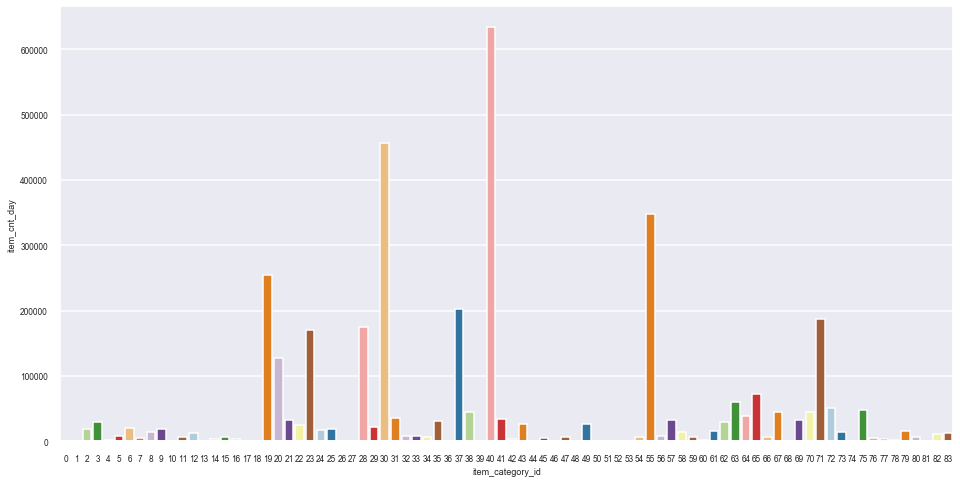

In [11]:
plt.figure(figsize=(16,8))
sns.set_context("talk", font_scale=0.5)
sales_item_cat = sales.merge(items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=sales_item_cat.reset_index(), 
            palette='Paired'
           );
del sales_item_cat

###  2) Data Leakage
Only the $42 \%$ of the all combinations item-shop that we have data appears in the test set. We model in order to take advantage of this data leakage as much as possible.

In [12]:
tuples_df = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(tuples_df.isin(tuples_test).sum()/len(tuples_df),2)*100)+'%')

42.0%


### 3) Feature Engineering: get a feature matrix
The set of ids that appear in the test set, once there is a historical sale, will be saved every subsequent month (including zero values). This strategy improves our model because it can infer the predictions about items not for sales in the test month (months with zero sales in a row). Moreover, we create the input for the submission with the date_block_num=34

We create the feature matrix for lags 1 to 3. We have improved the week 4 course function.

In [13]:
def get_feature_matrix(sales, test, items, list_lags, date_block_threshold):
    
    """ This function create the model tablon"""
  
    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Add submission shop_id-item_id in order to test predictions
    test['date_block_num'] = 34
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

In [14]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = sales[sales.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_for_modelling, test, items, list_lags, date_block_threshold)

In [15]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


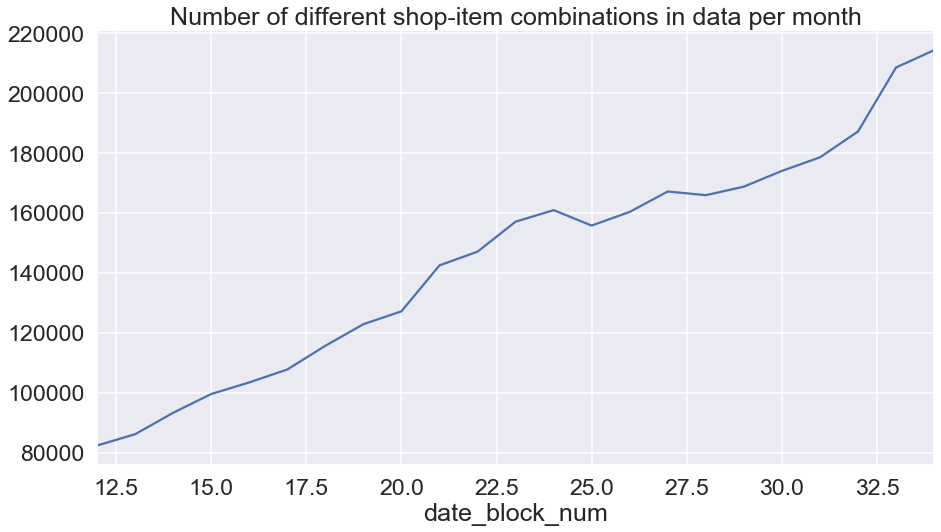

In [16]:
plt.figure(figsize=(15,8))
sns.set_context("talk", font_scale=1.4)
plt.title('Number of different shop-item combinations in data per month')
all_data.groupby('date_block_num').size().plot();

### 4) Advanced Feature Engineering
mean / variance encoding for category-id last month

In [17]:
mean_enc_item_cat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']
all_data = pd.merge(all_data, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
del mean_enc_item_cat
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37,0.512281,2.742767
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40,1.120868,10.631319
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37,0.512281,2.742767
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40,1.120868,10.631319
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55,0.902726,2.715576


### 5) Train/dev/test split strategy
We create a input dataframe for making the competition submission (date_block_num=34). The target is zero because we do not have the information sales for this month. We only get the model input from the table.

In [18]:
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
sub_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459


In [19]:
# Our validation set is associated with the months 22, 31, 32, 33.

dates = all_data['date_block_num']
boolean_test = (dates.isin([22,31,32,33])) # & (boolean)
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [21]:
#We save the data for the model grid search (differente notebook)
X_train.to_parquet('data/X_train.parquet')
X_val.to_parquet('data/X_val.parquet')
np.save(arr=y_train, file='data/y_train.npy')
np.save(arr=y_val, file='data/y_val.npy')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
pyarrow or fastparquet is required for parquet support

In [22]:
print('X_train shape is ' + str(X_train.shape))
print('X_val shape is ' + str(X_val.shape))

X_train shape is (2389620, 14)
X_val shape is (720954, 14)


In [23]:
print('Cross-validation is the {}'.format(round(X_val.shape[0]/X_train.shape[0],2)*100) )

Cross-validation is the 30.0


In [24]:
tuples_validation_submission = pd.Series(list(X_val[['item_id', 'shop_id']][dates_val==33].itertuples(index=False, name=None)))
print('The {} of the item_id-shop_id are in the cv set'.format(round(tuples_test.isin(tuples_validation_submission).sum()/len(tuples_test),2)*100))

The 93.0 of the item_id-shop_id are in the cv set


### 6) Modelling with stacking
Test meta-features

In [25]:
lgb = pickle.load(open('best_lgb.sav', 'rb'))

In [26]:
pred_lgb_val = lgb.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.890055
Val RMSE for lgb is 0.842925


In [27]:
feat_importances = pd.Series(lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

ValueError: Length of passed values is 16, index implies 14

In [ ]:
rf = pickle.load(open('../Example_Kernels/best_rf.sav', 'rb'))
pred_rf_val = clip20(rf.predict(X_val.fillna(0)))
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), pred_rf_val))

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance RF')
plt.show()

In [ ]:
plt.scatter(pred_rf_val, pred_lgb_val)

In [ ]:
X_val_level2 = np.c_[pred_rf_val, pred_lgb_val]

In [ ]:
# Stacking with linear regression

lr = LinearRegression()
lr.fit(X_val_level2, clip40(y_val))
pred_lr_val =  clip20(lr.predict(X_val_level2))
print('Test rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

In [ ]:
# Test data

pred_test_rf = rf.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
pred_test_lgb = lgb.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
X_test_level2 = np.c_[pred_test_rf, pred_test_lgb]


In [ ]:
test_pred = clip20(lr.predict(X_test_level2))

In [ ]:
test_pred.mean()

In [ ]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('../Example_Kernels/Predict_future_sales.csv',index=False)